# Прогнозирование оттока клиентов

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Информация о договорах актуальна на *1 февраля 2020*.    
- Основная метрика для проверки качества модели: `roc_auc`  
- Дополнительная метрика: `accuracy`  
  
### Описание Услуг
1) Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.  
2) Интернет. Подключение может быть двух типов: через телефонную линию DSL или оптоволоконный кабель Fiber optic.  

**Дополнительные услуги:**  
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

### Описание данных
Данные состоят из файлов, полученных из разных источников:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

###  исследовательский анализ данных

In [1]:
pip install phik -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import numpy as np

import datetime
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     cross_val_score,
                                     cross_validate,
                                     RandomizedSearchCV,
                                     StratifiedKFold
                                    )
import seaborn as sns

import phik

from phik import resources, report
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

import os
import seaborn as sns
import time
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import optuna
from sklearn.dummy import DummyClassifier
from catboost.utils import (get_roc_curve,
                            get_confusion_matrix
                           )
from optuna.integration import (CatBoostPruningCallback,
                                LightGBMPruningCallback
                                )

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, auc




import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import math
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve #график auc_roc
from sklearn.utils import shuffle #перемешивание при семплировании 

from sklearn.preprocessing import StandardScaler #масштабирование количественных признаков
pd.options.mode.chained_assignment = None

from sklearn.tree import DecisionTreeClassifier #дерево решений 
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)

In [4]:
RANDOM_STATE = 170723

#### Загружаем данные

In [5]:
contract = pd.read_csv("/datasets/contract_new.csv")
client = pd.read_csv("/datasets/personal_new.csv")
internet = pd.read_csv("/datasets/internet_new.csv")
phone = pd.read_csv("/datasets/phone_new.csv")

#### Посмотрим что из себя представляют данные по контрактам

In [6]:
contract.head()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
contract.describe()


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [8]:
print(contract.info())
contract.duplicated().sum()
pd.isnull(contract).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Среди данных дата начала и окончания действия контракта, тип контракта, "безбумажное" выставление счетов, способ платежа, ежемесячный платеж и общий платеж. Нет дубликатов и нет пропусков

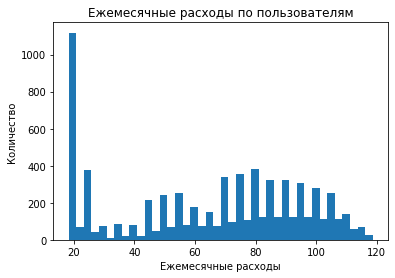

In [9]:
# Гистограмма для MonthlyCharges
plt.hist(contract['MonthlyCharges'], bins=40)
plt.xlabel('Ежемесячные расходы')
plt.ylabel('Количество')
plt.title('Ежемесячные расходы по пользователям')

plt.show()




Абонентская плата большинства пользователей - минимальная - 20$. Шанс, что они откажутся от услуг выше. 

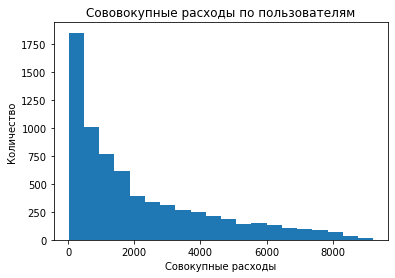

In [10]:
#Избавляемся пользователей, которые были подключены в день выгрузки базы и не сделали оплаты - по ним модель едва ли чему-то научится
contract = contract.loc[contract['TotalCharges'] != ' ']
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')


# Гистограмма для TotalCharges
plt.hist(contract['TotalCharges'], bins=20)
plt.xlabel('Совокупные расходы')
plt.ylabel('Количество')
plt.title('Сововокупные расходы по пользователям')
plt.show()

<div class="alert alert-warning">
<h3> Комментарий тимлида (план)<a class="tocSkip"> </h3>
    
<b>Некоторые замечания и рекомендации💡:</b> EndDate и TotalCharges находятся в ненадлежащем формате данных, что делает подписи значений на графиках нечитаемымы. Прежде чем строить графики, необходимо разобраться с типами данных.

<div class="alert alert-success">
<h3> Комментарий тимлида (план) 2<a class="tocSkip"> </h3>

<b>Отличная работа!👍:</b> 😉

In [11]:
# Гистограмма для End Date

#plt.hist(contract['EndDate'], bins=20)
#plt.xlabel('Совокупные расходы')
#plt.ylabel('Количество')
#plt.show()

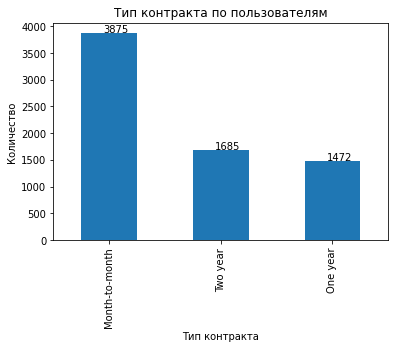

In [12]:
# Столбчатая диаграмма для Type с числовыми показателями
ax = contract['Type'].value_counts().plot(kind='bar')
plt.xlabel('Тип контракта')
plt.ylabel('Количество')
plt.title('Тип контракта по пользователям')


# Добавляем числовые показатели над каждым столбцом
for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()+10, str(round(i.get_height(), 2)), fontsize=10)

plt.show()

Почти 4 тысячи клиентов предпочитают ежемесячную оплату счетов. Более 1600 клиентов имеют двухлетний контракт и почти 1500 - однолетний. Шанс того, что люди на долгосрочном контракте уйдут - меньше, что стоит учитывать.

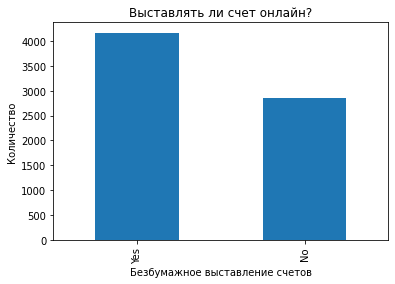

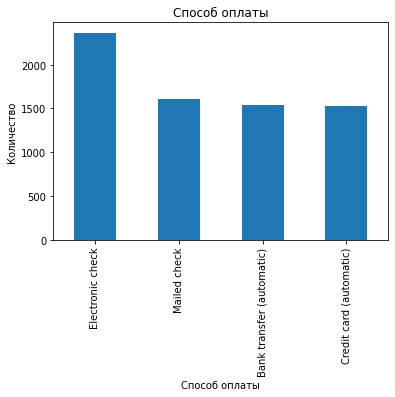

In [13]:
# Столбчатая диаграмма для PaperlessBilling
contract['PaperlessBilling'].value_counts().plot(kind='bar')
plt.xlabel('Безбумажное выставление счетов')
plt.ylabel('Количество')
plt.title('Выставлять ли счет онлайн?')

plt.show()

# Столбчатая диаграмма для PaymentMethod
contract['PaymentMethod'].value_counts().plot(kind='bar')
plt.xlabel('Способ оплаты')
plt.ylabel('Количество')
plt.title('Способ оплаты')

plt.show()

Большинство пользователей предпочитает безбумажный счет и оплату электронным чеком. остальные средства оплаты распределены равномерно. Нам важно, чтобы автоматические способы оплаты были более распространены.

#### Посмотрим что из себя представляют данные по клиентам

In [14]:
client.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [15]:
client.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
print(client.info())
client.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


0

В таблице у нас есть пол, является ли пользователь пожилым, есть ли супруг и зависимые субъекты (дети, вероятно). Дубликатов нет.

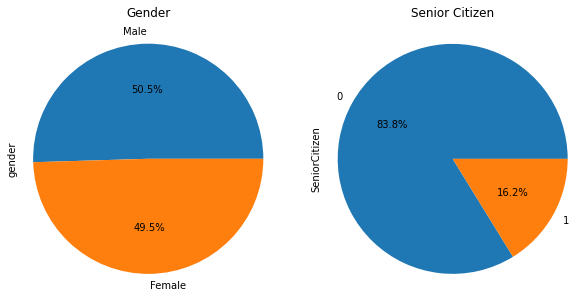

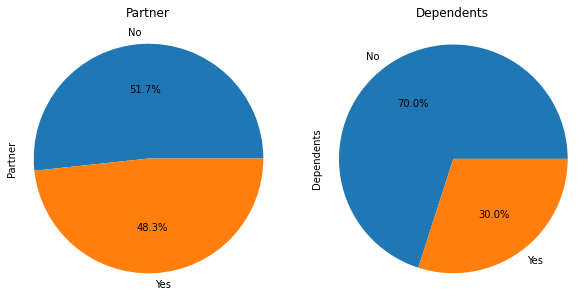

In [17]:
# Создаем два столбца и располагаем в них круговые диаграммы
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

#Круговая диаграмма для gender
client['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].axis('equal')
axs[0].set_title('Gender')

#Круговая диаграмма для SeniorCitizen
client['SeniorCitizen'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].axis('equal')
axs[1].set_title('Senior Citizen')

plt.show()

#Создаем два столбца и располагаем в них круговые диаграммы
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Круговая диаграмма для Partner
client['Partner'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].axis('equal')
axs[0].set_title('Partner')

# Круговая диаграмма для Dependents
client['Dependents'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].axis('equal')
axs[1].set_title('Dependents')

plt.show()

Распределение пола почти равномерное. Среди возрастных пользователей, 1, вероятно, значит, что пользователь относится к этой группе и таких пользователей чуть больше 16%.
Женатых чуть больше, не имеющих зависимых - 70%

#### Посмотрим что из себя представляют данные по использованию интернета

In [18]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [19]:
print(internet.info())
internet.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


0

Из услуг - доступ к интернету, онлайн-безопасность, бекап, защита устрйоства, техподдержка, стриминговое телевидение и фильмы.
Дубликатов нет

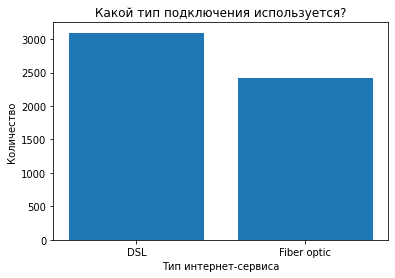

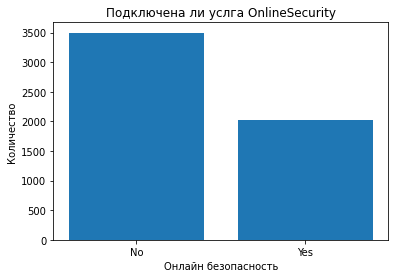

In [20]:
plt.bar(internet['InternetService'].unique(), internet['InternetService'].value_counts())
plt.xlabel('Тип интернет-сервиса')
plt.ylabel('Количество')
plt.title('Какой тип подключения используется?')

plt.show()

plt.bar(internet['OnlineSecurity'].unique(), internet['OnlineSecurity'].value_counts())
plt.xlabel('Онлайн безопасность')
plt.ylabel('Количество')
plt.title('Подключена ли услга OnlineSecurity')

plt.show()

Около трех тысяч пользователей находятся на DSL, остальные на оптике. Около 3,5 тыс человек не используют сервис онлайн-безопасности

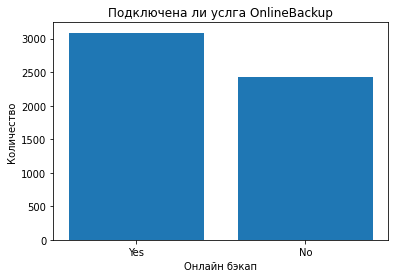

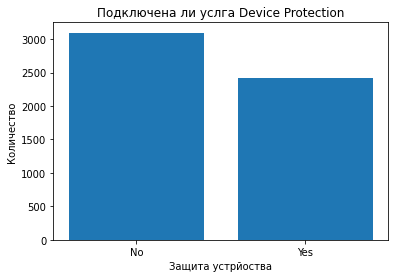

In [21]:
plt.bar(internet['OnlineBackup'].unique(), internet['OnlineBackup'].value_counts())
plt.xlabel('Онлайн бэкап')
plt.ylabel('Количество')
plt.title('Подключена ли услга OnlineBackup')
plt.show()

plt.bar(internet['DeviceProtection'].unique(), internet['DeviceProtection'].value_counts())
plt.xlabel('Защита устрйоства')
plt.title('Подключена ли услга Device Protection')
plt.ylabel('Количество')
plt.show()

А вот бекапы людям заходят. Большинство используют опцию. Защиту устрйоств используют меньшинство. Причем, выглядит, будто в данном случае услуги обратнопропорциональны.

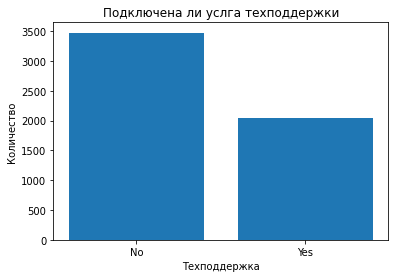

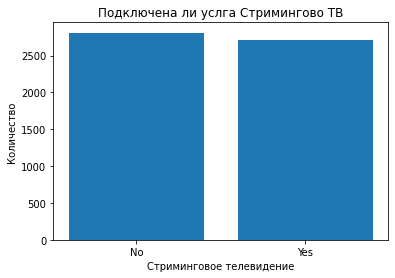

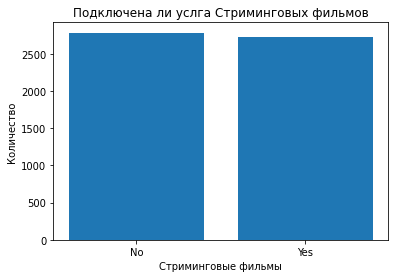

In [22]:
plt.bar(internet['TechSupport'].unique(), internet['TechSupport'].value_counts())
plt.xlabel('Техподдержка')
plt.ylabel('Количество')
plt.title('Подключена ли услга техподдержки')
plt.show()

plt.bar(internet['StreamingTV'].unique(), internet['StreamingTV'].value_counts())
plt.xlabel('Стриминговое телевидение')
plt.title('Подключена ли услга Стримингово ТВ')
plt.ylabel('Количество')
plt.show()

plt.bar(internet['StreamingMovies'].unique(), internet['StreamingMovies'].value_counts())
plt.xlabel('Стриминговые фильмы')
plt.title('Подключена ли услга Стриминговых фильмов')
plt.ylabel('Количество')
plt.show()

Стриминг разделися примерно на половину, а вот техподдержку люди реже подключают.

#### Посмотрим что из себя представляют данные по использованию телефонии

In [23]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [24]:
print(phone.info())
phone.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


0

В телефонии у нас только один показатель - использование нескольких линий

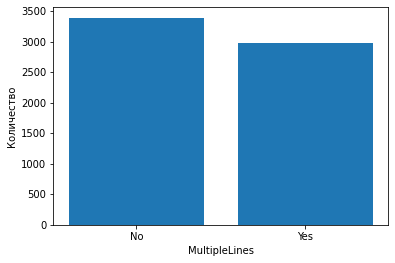

In [25]:
plt.bar(phone['MultipleLines'].unique(), phone['MultipleLines'].value_counts())
plt.xlabel('MultipleLines')
plt.ylabel('Количество')
plt.show()

Чуть меньше половины использует несколько линий.

### Для дальнейшей работы соберем все данные в одну таблицу, объединив их по customerID

In [26]:
data_all = contract.merge(right=client, how='left', on='customerID')
data_all = data_all.merge(right=internet, how='left', on='customerID')
data_all = data_all.merge(right=phone, how='left', on='customerID')

In [27]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null   object 


In [28]:
data_all.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Вопросы:
1. Какие критерии определяют отток клиентов?
2. Какие услуги наиболее часто используются клиентами?
3. Какие факторы влияют на выбор определенного способа расчета за услуги?
4. Какие промокоды и специальные условия могут быть предложены клиентам, которые планируют уйти?
5. Как появляются и исчезают услуги и как они раскрыты в таблице? Есть ли в компании план на появление новых, исключение или обхединение сушествующих услуг? (хочу понять, какими из услуг можно пренебречь)
6. Какая дата среза данных?

Примерный план решения задачи:
1. Изучение данных и их предобработка (загрузка данных, ознакомление с ними, преобразование данных, объединение таблиц).
2. Выбор целевого показателя, анализ корреляции между признаками и оттоком клиентов, предотвращение мультиколлинеарности, отбор признаков.
3. Разделение данных на обучающую и тестовую выборки, кодирование.
4. Обучение моделей машинного обучения для прогнозирования оттока клиентов, подбор гиперпараметров (на кроссвалидации с GridSearchCV).
5. Оценка качества моделей и выбор наилучшей, проверка по ROC_AUC, построение графика ROC, анализ accuracy, подготовка матрицы ошибок
6. Подготовка отчета по проделанной работе, включая рекомендации на основе полученных данных.

Цель проекта: разработать модель машинного обучения для прогнозирования оттока клиентов оператора связи и предложить им промокоды и специальные условия для удержания.

## Подготовка к обучению моделей

In [29]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   int64  
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null   object 


### Преобразуем поле тип контракта

In [30]:
data_all['BeginDate'] = pd.to_datetime(data_all['BeginDate'])

In [31]:
# Замена значений NO из enddate на дату снятияя показаний -- 2020-02-01
data_all.loc[data_all['EndDate'] == 'No', 'EndDate'] = pd.to_datetime('2020-02-01')
data_all.EndDate = pd.to_datetime(data_all.EndDate)

In [32]:
#Определеяем количество дней контракта пользователя
data_all['total_days'] = (data_all['EndDate'] - data_all['BeginDate']).dt.days

In [33]:
data_all.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,total_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


In [34]:
data_all.isna().sum()


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
total_days             0
dtype: int64

### Преобразуем данные

In [36]:
# Список колонок для изменения

bool_cols = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', \
             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', \
            'StreamingMovies']
internet_options = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', \
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService']

In [37]:
# Преобразуем колонки не в No, а подразделяем их - в данном случае "без телефона"
data_all['MultipleLines'] = data_all['MultipleLines'].fillna('no_phone')
data_all['SeniorCitizen'] = data_all['SeniorCitizen'].astype('int')


In [38]:
#без интернета
data_all[internet_options] = data_all[internet_options].fillna('no_internet')


In [39]:
# Преобразуем тип данных колонки с итоговыми затратами
data_all['TotalCharges'] = pd.to_numeric(data_all['TotalCharges'], errors='coerce').fillna(0)


In [40]:
# Приравняем итоговые траты к месячным, если они меньше
data_all['TotalCharges'] = data_all.apply(lambda row: row['MonthlyCharges'] if row['TotalCharges'] < row['MonthlyCharges'] \
                               else row['TotalCharges'], axis=1)

In [41]:
data_all.isna().sum()


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
total_days          0
dtype: int64

### Объявляем целевой признак - ушел ли клиент

In [42]:

data_all['out'] = (data_all['EndDate'] != datetime.datetime(2020,2,1)).astype(int)


Выводы: данные успешно загружены, создан целевой признак, удалены признаки начала и конца действия договора для устранения утечки данных. Преобразованы типы данных для булевых признаков, устранены пропуски.

### Оценка баланса классов

In [43]:
#Оценим баланс классов
data_all['out'].value_counts(normalize=True)


0    0.84343
1    0.15657
Name: out, dtype: float64

По целевому признаку заметен сильный дисбаланс классов, однако, в предполагаемых моделях МО есть встроенные алгоритмы для борьбы с этим явлением. Масштабирование признаков не проводилось, так как деревянные модели и бустинги не имеют проблем с работой на немастабированных данных.

### Дополнительный анализ соотношения признаков и ухода клиента

<AxesSubplot:xlabel='out', ylabel='MonthlyCharges'>

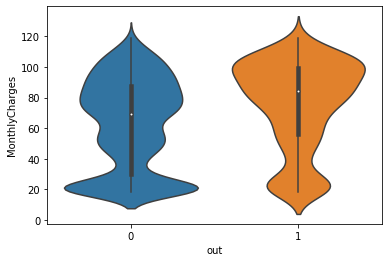

In [48]:
sns.violinplot(x='out', y='MonthlyCharges', data=data_all)


Видим, как есть всплеск ухода на ~20 и  на 100 у.e.

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

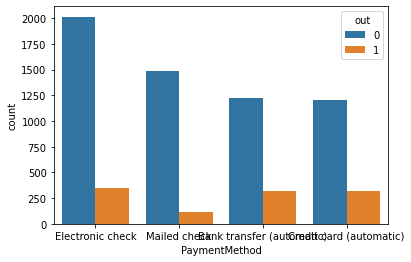

In [49]:
sns.countplot(x='PaymentMethod', hue='out', data=data_all)


Доля ушедших в абсолютных значениях оказалась наименьшей при отправляемом чеке. Интересно, почему так. В относительных - при электронной оплате. 

<AxesSubplot:xlabel='Type', ylabel='count'>

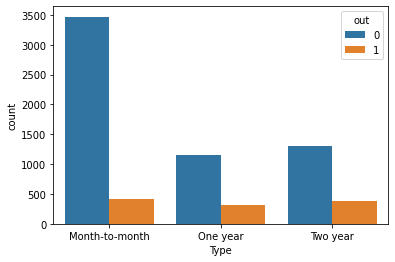

In [50]:
sns.countplot(x='Type', hue='out', data=data_all)


Доля ушедших при ежемесячной оплате ниже, чем при других типах.

<AxesSubplot:xlabel='InternetService', ylabel='count'>

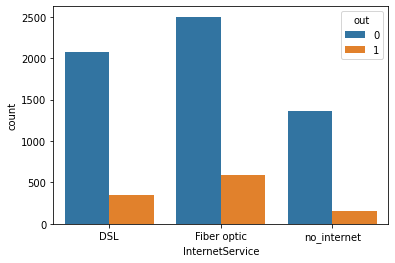

In [51]:
sns.countplot(x='InternetService', hue='out', data=data_all)

Число ушедших больше при использовании оптики.

### Корреляция

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'total_days', 'out']


<AxesSubplot:>

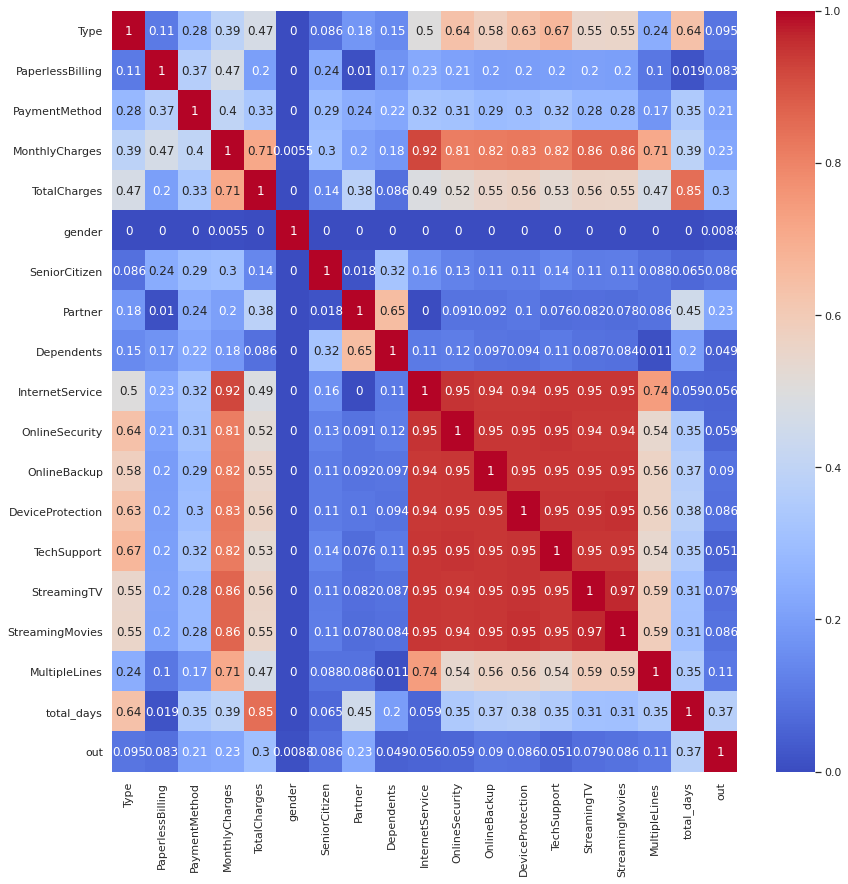

In [52]:
phik = data_all.drop(['customerID', 'BeginDate', 'EndDate'], axis=1).phik_matrix()
sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(phik, annot=True, cmap='coolwarm')

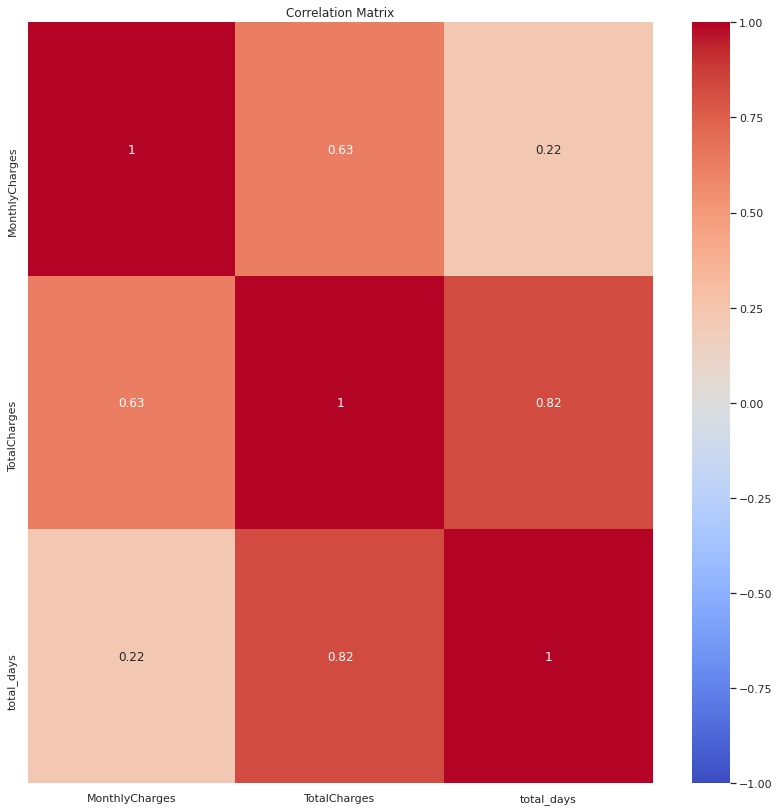

In [53]:
numeric_features = ['MonthlyCharges','TotalCharges','total_days']
sns.heatmap(data_all[numeric_features].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Изучение матрицы корреляции признаков показало наличие мультиколлинеарности (например, TotalCharges - мультиколлинеарный по отношению к total_days - суммарные траты клиентов сильно зависят от времени подключения к провайдеру, что логично.
), но используемые в проекте модели отлично справляются с этим явлением, что позволяет нам не избавляться от таких признаков. Также, в дальнейшем мы могли бы отбросить признаки пола и наличия иждивенцев, так как они не имеют корреляции с другими признаками.

### Удаление столбцов

In [54]:
#удаляем лишние столбцы
data_all = data_all.drop(('customerID'), axis=1)
data_all = data_all.drop(('BeginDate'), axis=1)
data_all = data_all.drop(('EndDate'), axis=1)


## Обучение

Посмотрим на трех моделях: Случайный Лес и LGBM

### Разбиение на выборки

In [55]:
# Разобьём данные на тренировочные и тестовые
features_train, features_test, target_train, target_test = train_test_split(data_all.drop('out', axis=1), 
                                                                            data_all['out'], test_size=0.25, 
                                                                            stratify=data_all['out'], 
                                                                            random_state=RANDOM_STATE)


In [56]:
# Сбросим индексы
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)


In [57]:
# Удаление неинформативных признаков
drop_cols = ['Dependents', 'gender']
features_train.drop(drop_cols, axis=1, inplace=True)
features_test.drop(drop_cols, axis=1, inplace=True)

### кодирование признаков

In [58]:
# Сохраним список категориальных числовых признаков
NUM_FEATURES = ['MonthlyCharges', 'total_days', 'TotalCharges']
CAT_FEATURES = list(features_train.columns)

for feature in NUM_FEATURES:
    CAT_FEATURES.remove(feature)

for col in CAT_FEATURES:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

In [59]:
# Сделаем кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

In [60]:
# Создадим копии датафреймов
features_train_coded = encoder.fit_transform(features_train[CAT_FEATURES].copy())
features_test_coded = encoder.transform(features_test[CAT_FEATURES].copy())

In [61]:
#Создание нового датафрейма с помощью pandas
features_train_encoded = pd.DataFrame(features_train_coded, columns=encoder.get_feature_names())
features_test_encoded = pd.DataFrame(features_test_coded, columns=encoder.get_feature_names())

In [62]:
#добавляем числовые признаки
for feature in NUM_FEATURES:
    features_train_encoded[feature] = features_train[feature]
    features_test_encoded[feature] = features_test[feature]

In [63]:
#Проверим размерности выборок
print('Тренировочная выборка:')
print(features_train.shape)
print(features_train_encoded.shape)
print(target_train.shape)
print('Тестовая выборка:')
print(features_test.shape)
print(features_test_encoded.shape)
print(target_test.shape)

Тренировочная выборка:
(5274, 16)
(5274, 27)
(5274,)
Тестовая выборка:
(1758, 16)
(1758, 27)
(1758,)


In [64]:
# Список для результатов проверки моделей на CV
results = {}

### случайный лес

In [65]:
# GridSearchCV
parameters = {'max_depth': [4,6,8,10,12],
               'n_estimators': [100,500,1000],
              }

# Осуществим подбор гиперпараметров по сетке в кросс-валидации для первой модели
rfc_tuner = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),param_distributions=parameters,scoring=['roc_auc', 'accuracy'],cv=3,verbose=10, n_jobs=-1,  refit='roc_auc')
rfc_tuner.fit(features_train_encoded, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START max_depth=10, n_estimators=100.............................
[CV 1/3; 1/10] END max_depth=10, n_estimators=100; accuracy: (test=0.859) roc_auc: (test=0.820) total time=   0.4s
[CV 2/3; 1/10] START max_depth=10, n_estimators=100.............................
[CV 2/3; 1/10] END max_depth=10, n_estimators=100; accuracy: (test=0.854) roc_auc: (test=0.811) total time=   0.3s
[CV 3/3; 1/10] START max_depth=10, n_estimators=100.............................
[CV 3/3; 1/10] END max_depth=10, n_estimators=100; accuracy: (test=0.865) roc_auc: (test=0.808) total time=   0.3s
[CV 1/3; 2/10] START max_depth=12, n_estimators=1000............................
[CV 1/3; 2/10] END max_depth=12, n_estimators=1000; accuracy: (test=0.861) roc_auc: (test=0.819) total time=   3.6s
[CV 2/3; 2/10] START max_depth=12, n_estimators=1000............................
[CV 2/3; 2/10] END max_depth=12, n_estimators=1000; accuracy: (test=0.854

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=170723),
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8, 10, 12],
                                        'n_estimators': [100, 500, 1000]},
                   refit='roc_auc', scoring=['roc_auc', 'accuracy'],
                   verbose=10)

In [66]:
rfc_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'random_state': 180723
}

In [67]:
# Создание модели RandomForest
rfc_model = RandomForestClassifier(**rfc_params)

# Определение функций оценки для ROC-AUC и Accuracy
scoring = ['roc_auc','accuracy']

# Создание экземпляра StratifiedKFold с параметром shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Вычисление ROC AUC и accuracy с использованием cross_validate и заданными параметрами cv
rfc_cv_scores = pd.DataFrame(cross_validate(rfc_model, features_train_encoded, target_train, cv=cv, scoring=scoring, verbose=10, n_jobs=-1))


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ....... accuracy: (test=0.856) roc_auc: (test=0.811) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ....... accuracy: (test=0.862) roc_auc: (test=0.833) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ....... accuracy: (test=0.860) roc_auc: (test=0.807) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV] END ....... accuracy: (test=0.854) roc_auc: (test=0.836) total time=   0.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s


[CV] END ....... accuracy: (test=0.855) roc_auc: (test=0.821) total time=   0.3s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


In [68]:
results['RandomForest'] = [rfc_cv_scores['test_roc_auc'].mean(),rfc_cv_scores['test_accuracy'].mean(),(rfc_cv_scores['fit_time'] + rfc_cv_scores['score_time']).mean()]

### LightGBM

In [68]:
# Подбор гиперпараметров с OPTUNA
def objective(trial: optuna.Trial) -> float:
    data, target = features_train_encoded, target_train
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 400, 1900, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state": RANDOM_STATE
  #      "categorical_feature": "name:"+CAT_FEATURES
     }


    gbm = lgb.LGBMClassifier(**param)
    cv_results = cross_val_score(gbm, data, target, cv=5, scoring='roc_auc')
    score = cv_results.mean()

    return score

    pruning_callback = LightGBMPruningCallback(trial, "auc")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    


if __name__ == "__main__":
    sampler = optuna.samplers.TPESampler(seed=42)

    study = optuna.create_study(
        pruner=optuna.pruners.HyperbandPruner(min_resource=25), direction="maximize", sampler = sampler
    )
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-07-28 02:32:28,599] A new study created in memory with name: no-name-b0787990-a568-4e34-96b0-08e5fd666ea8


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[W 2023-07-28 02:32:34,677] Trial 0 failed with parameters: {'n_estimators': 900, 'learning_rate': 0.36808608148776095, 'num_leaves': 750, 'subsample': 0.6187255599871848, 'colsample_bytree': 0.19821770842031466, 'min_data_in_leaf': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_31/3984962666.py", line 23, in objective
    cv_results = cross_val_score(gbm, data, target, cv=5, scoring='roc_auc')
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 440, in cross_val_score
    cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", li

KeyboardInterrupt: 

In [73]:
# Параметры, подобранные с Optuna
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "bagging_freq": 1,
    "n_estimators": 400,
    "learning_rate": 0.21766241123453672,
    "num_leaves": 616,
    "subsample": 0.7226689489062432,
    "colsample_bytree": 0.06955526958101232,
    "min_data_in_leaf": 97,
    "random_state": RANDOM_STATE
}

In [74]:
#Создание модели LightGBM
lgb_model = lgb.LGBMClassifier(**lgb_params)

#Определение функций оценки для ROC-AUC и Accuracy
scoring = ['roc_auc','accuracy']

#Создание экземпляра StratifiedKFold с параметрами shuffle и stratify
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#Вычисление ROC AUC и accuracy с использованием cross_val_score и заданными параметрами cv
lgb_cv_scores = pd.DataFrame(cross_validate(lgb_model, features_train_encoded, target_train, cv=cv, scoring=scoring, verbose=10, n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[CV] END ....... accuracy: (test=0.887) roc_auc: (test=0.882) total time= 1.2min
[CV] START .....................................................................
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] END ....... accuracy: (test=0.891) roc_auc: (test=0.887) total time=  16.2s
[CV] START .....................................................................
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] END ....... accuracy: (test=0.890) roc_auc: (test=0.872) total time=  22.5s
[CV] START .....................................................................
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV] END ....... accuracy: (test=0.899) roc_auc: (test=0.896) total time=  17.0s
[CV] START .....................................................................
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV] END ....... accuracy: (test=0.885) roc_auc: (test=0.881) total time=  35.2s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [75]:
results['LightGBM'] = [lgb_cv_scores['test_roc_auc'].mean(),lgb_cv_scores['test_accuracy'].mean(),(lgb_cv_scores['fit_time'] + lgb_cv_scores['score_time']).mean()]

In [76]:
for elem in results:
    print(elem, 'ROC-AUC:', results[elem][0])
    print(elem, 'Accuracy:', results[elem][1])
    print(elem, 'Fitting time:', results[elem][2])
    print('- ' * 20)

RandomForest ROC-AUC: 0.8216722852971337
RandomForest Accuracy: 0.8572236661061
RandomForest Fitting time: 0.33800902366638186
- - - - - - - - - - - - - - - - - - - - 
LightGBM ROC-AUC: 0.8833869898706637
LightGBM Accuracy: 0.890404777107296
LightGBM Fitting time: 32.553661298751834
- - - - - - - - - - - - - - - - - - - - 


Вернулся LGBM с результатом в 0,88


### Тестирование модели

In [77]:
lgb_model.fit(features_train, target_train)


# Получение предсказаний модели
lgb_predictions_proba = lgb_model.predict_proba(features_test)[:, 1]



[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


### График ROC-AUC

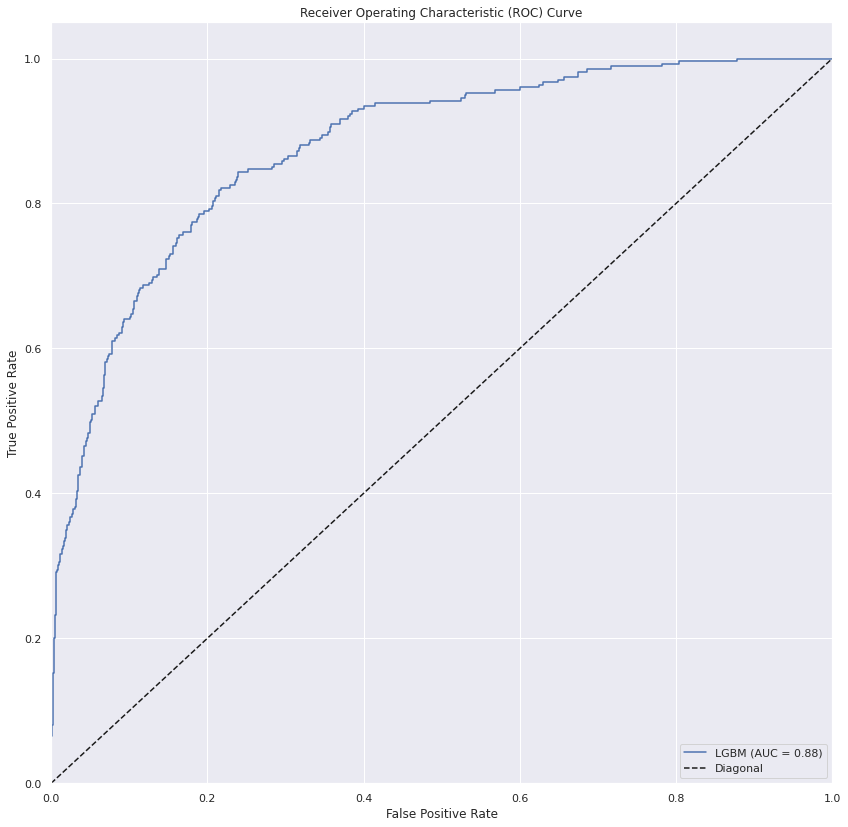

ROC-AUC на тестовой выборке: 0.8771507386746766


In [78]:
# Вычисление значений false positive rate (fpr) и true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(target_test, lgb_predictions_proba)

# Вычисление значения площади под ROC-кривой (AUC)
auc = roc_auc_score(target_test, lgb_predictions_proba)

# Построение ROC-кривой
plt.plot(fpr, tpr, label='LGBM (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Diagonal')

# Настройка графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Отображение графика
plt.show()

print("ROC-AUC на тестовой выборке:", auc)

In [79]:
lgb_predictions = lgb_model.predict(features_test)

accuracy = accuracy_score(target_test, lgb_predictions)
print("Accuracy на тестовой выборке:", accuracy)

Accuracy на тестовой выборке: 0.8782707622298066


В этом коде мы используем функцию predict_proba для получения предсказанных вероятностей класса 1 (lgbm_predictions_proba) с помощью модели LGBMClassifier и метода predict_proba. Затем мы используем функцию roc_auc_score для расчета ROC-AUC метрики, передавая истинные метки (target_test) и предсказанные вероятности класса 1 (lgbm_predictions_proba).

### Матрица ошибок

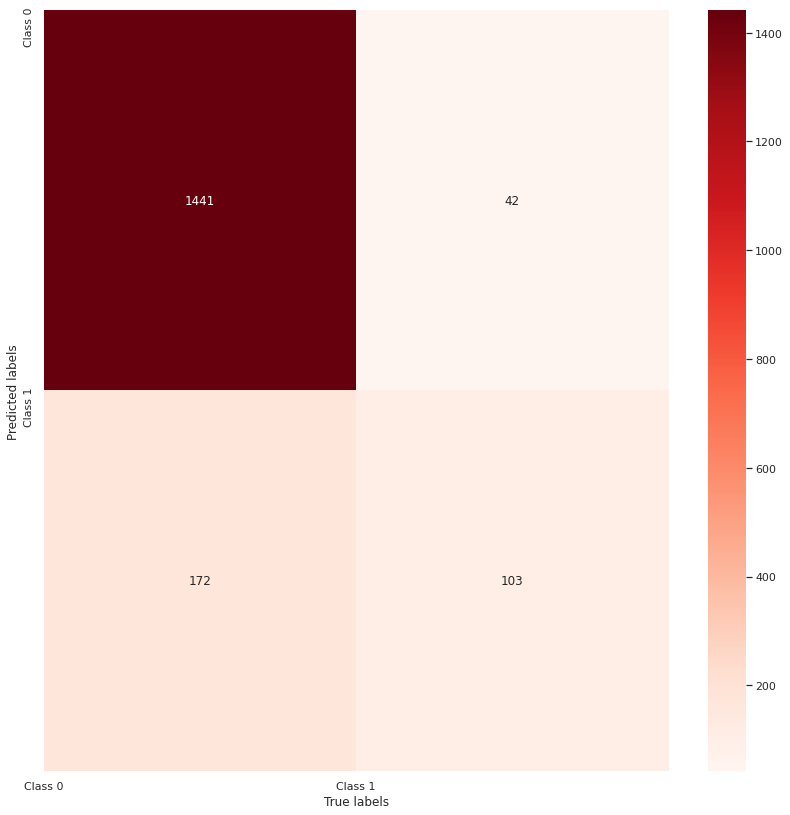

In [80]:
threshold = 0.5
binary_predictions = (lgb_predictions_proba >= threshold).astype(int)

# Создание матрицы ошибок
lgb_cm = confusion_matrix(target_test, binary_predictions)


# Создание тепловой карты для матрицы ошибок
sns.heatmap(lgb_cm, annot=True, fmt='g', cmap='Reds')

# Настройка осей и добавление меток классов
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])

# Отображение графика
plt.show()

### Важность признаков

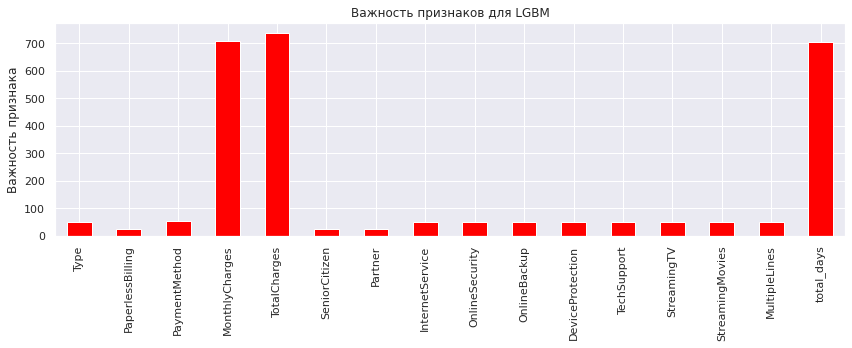

In [81]:
feature_importance_lgb = lgb_model.feature_importances_
feature_importance = pd.Series(feature_importance_lgb, index=features_test.columns)

fig, ax = plt.subplots(figsize=(12, 5))
feature_importance.plot.bar(ax=ax, color='red', grid=True)
ax.set_title("Важность признаков для LGBM")
ax.set_ylabel('Важность признака')
fig.tight_layout()

plt.show()

Поставленная цель по потроению модели машинного обучени модели LGBMClassifier выполнена. Модель показала требуемую метрику на тестовых данных. Метрика ROC-AUC: 0.88, Accuracy: 0.89.
Модель сделала:
172 ложно-негативных предсказаний - количество неправильно предсказанных неоттоков клиентов (когда модель предсказала, что клиент останется, но он ушел - самый негативный сценарий - в процентном соотношении таких ошибок мало)  
42 ложно-положительных - количество неправильно предсказанных оттоков клиентов (когда модель предсказала отток, но клиент остался - дали ему промокод - ничего страшного - повысили лояльность).

1441 - правильных позитивных предсказаний - количество правильно предсказанных оттоков клиентов, 
103 - правильно негативных - количество правильно предсказанных неоттоков клиентов.


Важность признаков для модели. Наиболее важными признаками являются длительность договора, суммарные траты, ежемесячные траты, тип договора по сроку.

На основе рпо данной модели можно выбирать наиболее правильные промоакции для удержания клиентов. В модель на регулярной основе можно добавлять данные и проверять ее работу на обновленных датасетах, а также, ввести новые признаки - выдан ли промокод и смотреть, насколько и для каких категорий "плюшки" работают.


## Обший вывод


В ходе работы успешно загружены данные из нескольких таблиц, таблицы объединены в один датасет.
Произведена работа над пропусками, приведение данных к нужному типу.

Произведен анализ данных.
Распределение пола почти равномерное. Среди возрастных пользователей, 1, вероятно, значит, что пользователь относится к этой группе и таких пользователей чуть больше 16%.
Женатых чуть больше, не имеющих зависимых - 70%


Почти 4 тысячи клиентов предпочитают ежемесячную оплату счетов. Более 1600 клиентов имеют двухлетний контракт и почти 1500 - однолетний. Шанс того, что люди на долгосрочном контракте уйдут - меньше, что стоит учитывать.

Большинство пользователей предпочитает безбумажный счет и оплату электронным чеком. остальные средства оплаты распределены равномерно. Для целей удержания клиентов косвенно важно, чтобы автоматические способы оплаты были более распространены.


Изучение матрицы корреляции признаков показало наличие мультиколлинеарности, однако используемые в проекте модели справляются с этим явлением, что позволяет нам не избавляться от таких признаков. Мы можем отбросить признаки пола(gender) и наличия иждивенцев(dependents), так как они не имеют корреляции с другими признаками.

По целевому признаку заметен сильный дисбаланс классов, однако, в предполагаемых моделях машинного обучения есть встроенные алгоритмы для борьбы с этим явлением. Масштабирование признаков не проводилось, так как деревянные модели и бустинги не имеют проблем с работой на немасштабированных данных.

Подготовлены выборки для обучения моделей, в том числе, выделены категориальные признаки и их кодирование методом OHE. Осуществлен подбор гиперпараметры и обучены на кросс-валидации две модели: RandomForest и LightGBM.

Модель RandomForest не смогла достичь целевого значения метрики AUC-ROC в 0.85. Все остальные модели справились с требуемой задачи. В плане метрик, LightGBM оказался  более результативным, его метрика AUC-ROC составила 0.88 на кросс-валидации.

Оценка матрицы ошибок:

Модель сделала 172 ложно-негативных - количество неправильно предсказанных неоттоков клиентов (когда модель предсказала, что клиент останется, но он ушел - самый негативный сценарий - в процентном соотношении таких ошибок мало) предсказаний и 42 ложно-положительных - количество неправильно предсказанных оттоков клиентов (когда модель предсказала отток, но клиент остался - дали ему промокод - ничего страшного - повысили лояльность).

В целях данной работы для нас наиболее важны позитивные предсказания модели, чтобы компания могла осуществлять действия для удержания клиентов. Правильных позитивных предсказаний модель сделала 1441 - количество правильно предсказанных оттоков клиентов, правильно негативных - 103 - количество правильно предсказанных неоттоков клиентов.

Оценка важности признаков:
Наиболее важными признаками являются длительность договора, суммарные траты, ежемесячные траты, тип договора по сроку, методы оплаты.

По итогам работы, можно рекомендовать модель к использованию, её применение поможет сохранять лояльных клиентов компании. В дальнейшем следует проводить исследования с целью дальнейшей минимизации ложно негативных предсказаний модели.

## Отчёт по решению


### Какие пункты плана были выполнены, а какие — нет. Почему?

Цель проекта: разработать модель машинного обучения для прогнозирования оттока клиентов оператора связи и предложить им промокоды и специальные условия для удержания - достигнута.

Были изучены данные и проведена их предобработка (загрузка данных, ознакомление с ними, преобразование данных, объединение таблиц). Затем я выбрал целевой показатель, провел анализ корреляции между признаками, описал особенности мультиколлинеарности в данном случае.
Проведено разделение данных на обучающую и тестовую выборки, кодирование OHE.
Обучение моделей машинного обучения для прогнозирования оттока клиентов, подбор гиперпараметров (на кроссвалидации с GridSearchCV). Подбор гиперпараметров прошел на Optuna, а не на GridSearch по рекомендации Тимлида.
Была проведена оценка качества моделей и выбор наилучшей из двух использованных, проверка по ROC_AUC, построение графика ROC, анализ accuracy (хоть и из-за дисбаланса мы не можем полагаться на неею), подготовка матрицы ошибок
Подготовка отчета по проделанной работе, включая рекомендации на основе полученных данных.

В общем, все пункты плана были выполнены, часть из них видоизменилась в процессе.

### Какие трудности возникли и как вы их преодолели?
Трудности возникли как организационного плана, так и в процессе фактического выполнения.

Из организационных - накладки по таймингу обучения и внеучебной активности.
По фактическим:
1) ошибка с объединением таблиц - inner/outer.
2) ошибка в матрице корреляций и изначальном отсутствии хитмэп по отдельным признакам
3) ошибка с кроссвалидацией, проводимой после уже подобранных гиперпараметров, 
4) ошибка с моделью CatBoost, с которой еще нужно будет разбираться.
5) изначально незафиксированный random_state.
6) ошибка с расчетом метрик и построением графика ROC_AUC.
7) и ряд других недоработок по коду, которые были устранены с помощью наводящих установок Тимлидера или поиском подходящих вариантов в документации. 

Из трудностей по самой задачи:
На мой взгляд данных для модели маловато, нет информации о динамике тарифов и услуг (появления новых и отключения старых и изменения цен по тарифам) - телеком компании не живут в стабильных тарифных планах.

### Какие ключевые шаги в решении задачи вы выделили?

- Exploratory data analysis (EDA);
- Feature engineering;
- Извлечение ключевого признака;
- Уточнение задачи;
- Составление плана решения задачи;
- Разделение на выборки и кодирование данных;
- Оптимизация гиперпараметров моделей;
- Оценка моделей и тестирование лучшей модели;
- Написание вывода по работе.

### Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Я использовал все признаки, кроме ID пользователя, начальной и заключительной даты (так как у нас появилась длительность договора), а также исключил пол и наличие иждевенцев. 

Плюс был добавлен целевой признак - завершился контракт или нет.
Также проведено кодирование данных.

В данной работе вообще можно было не отказываться от признаков, так как их общее количество не велико.

### Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Итоговая модель LGBMClassifier.

Параметры, подобранные с Optuna
```lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "bagging_freq": 1,
    "n_estimators": 400,
    "learning_rate": 0.21766241123453672,
    "num_leaves": 616,
    "subsample": 0.7226689489062432,
    "colsample_bytree": 0.06955526958101232,
    "min_data_in_leaf": 97,
    "random_state": RANDOM_STATE'
```
LightGBM ROC-AUC: 0.8833869898706637 <br>
LightGBM Accuracy: 0.890404777107296 <br>
ROC-AUC на тестовой выборке: 0.8771507386746766 <br>
Accuracy на тестовой выборке: 0.8782707622298066